In [1]:
# Imports
import cv2
import os
import numpy as np
import pandas as pd
import shutil
import kagglehub
import keras

import tensorflow as tf
from keras.applications import MobileNetV2, ResNet50V2
from keras import layers, models
from keras.optimizers import Adam
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LeakyReLU, BatchNormalization

# Visualization
import matplotlib.pyplot as plt

## Handtracking and Image modification
from cvzone.HandTrackingModule import HandDetector
from skimage.morphology import skeletonize
from skimage.measure import label, regionprops

/home/lizardman/Coding/Projet_Machine_Learning_Air_Drawing/venv312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-05 22:01:13.208320: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-05 22:01:13.215742: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-05 22:01:13.273508: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-05 22:01:13.327148: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register

# Projet - Air Drawing
---
EXPLICATION DE LA PROBLEMATIQUE

## Datsets
---

### Autre Dataset
Explication de pourquoi est ce qu'on ne la pas pris car moins bien etc
Solution : EMNIST

### EMNIST
Le jeu de données EMNIST (Extended MNIST) est un ensemble de caractères manuscrits dérivé de la base de données NIST Special Database 19. Il a été converti au format d’image 28x28 pixels, avec une structure de données qui correspond directement à celle du jeu de données MNIST. EMNIST étend MNIST en incluant non seulement des chiffres, mais aussi des lettres majuscules et minuscules manuscrites, offrant ainsi un ensemble plus riche pour les tâches de reconnaissance de caractères.

In [2]:
# Télécharger dans le dossier par défaut non modifiable (cache de kagglehub)
dataset_path = kagglehub.dataset_download("crawford/emnist")

# Dossier cible
custom_path = "./Datasets/emnist_datasets"
os.makedirs(custom_path, exist_ok=True)

# Parcourir tout ce qu’il y a dans dataset_path
for item in os.listdir(dataset_path):
    src = os.path.join(dataset_path, item)
    dst = os.path.join(custom_path, item)
    shutil.move(src, dst)

100%|██████████| 1.24G/1.24G [03:32<00:00, 6.25MB/s]

Extracting files...


### EMNIST (By_Class)
L'ensemble complet de la base de données EMNIST est disponible dans le sous-ensembles ByClass.
Le jeu ByClass contient 62 classes distinctes : les 10 chiffres (0–9), les 26 lettres majuscules (A–Z) et les 26 lettres minuscules (a–z).
La répartition est déséquilibrée : certaines classes ont beaucoup plus d’exemples que d’autres.
La fréquence des lettres reflète à peu près leur fréquence d'usage dans la langue anglaise.

__Taille des ensembles :__
- Entraînement : 697 932 images
- Test : 116 323 images
- Total : 814 255 images

__Classes :__
- ByClass : 62 classes (déséquilibrées)


In [5]:
# Recupération des train_data de EMNITST
train_data = pd.read_csv('./Datasets/emnist_datasets/emnist-byclass-train.csv', header=None, nrows=300000).to_numpy()
# Dataset Comprends 697 932 entrées, par raison de performances nous avons limités la charge à 300K.
print(train_data.shape)

(300000, 785)


In [6]:
# Recupération des test_data de EMNITST
test_data = pd.read_csv('./Datasets/emnist_datasets/emnist-byclass-test.csv', header=None).to_numpy()
print(test_data.shape)

(116323, 785)


Les test_data permet au modèle de voir s'il se généralise bien et qu'il ne fait pas du sur-apprentissage (évaluation époque par époque).
Pratique pour stopper ou débugger l'entrainement du modèle.

W


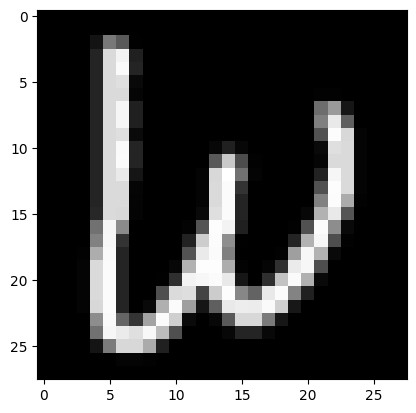

In [7]:
# Recupération des label_mapping de EMNITST
label_mapping = np.genfromtxt('./Datasets/emnist_datasets/emnist-byclass-mapping.txt', delimiter=' ')

label_trans = {}
for label in label_mapping:
    label_trans[label[0]] = chr(int(label[1]))

# Exemple d'une donnée EMNIST
img_nb = 150
print(label_trans[train_data[img_nb,0]])
plt.imshow(train_data[img_nb,1:].reshape(28,28).T, cmap='gray')
plt.show()

In [8]:
# Préparation des données :

# 1) Séparation des labels "y" et les données de l'image "x"
# Entrainement
train_x = train_data[:,1:]
train_y = train_data[:,0]
# Test
test_x = test_data[:,1:]
test_y = test_data[:,0]

# 2) Normalisation (valeur des "x" entre 0 et 1) -> Plus facile pour l'entrainement
train_x = train_x / 255.0
test_x = test_x / 255.0

# 3) Reshape (Keras attend un format [batch_size, hauteur, largeur, canaux])
train_count = train_x.shape[0]
train_x = train_x.reshape(train_count, 28, 28, 1)

test_count = test_x.shape[0]
test_x = test_x.reshape(test_count, 28, 28, 1)

# 4) Transformation des labels (Chiffre en vecteur binaire)
num_classes = 63 # (62 catégorie allant de 1 à 62 donc liste de longueur 63)

train_y = keras.utils.to_categorical(train_y, num_classes)
test_y = keras.utils.to_categorical(test_y, num_classes)

Nos données provenant du dataset EMNIST(By_Class) sont maintanant pretes à etre utiliser dans nos différents modèle.

### EMNIST (Letters)
Le jeu de données EMNIST Letters fusionne un ensemble équilibré de lettres majuscules et minuscules en une seule tâche de classification à 26 classes (une par lettre de l’alphabet).

- Entraînement : 88 800 images
- Test : 14 800 images
- Total : 103 600 images
- Nombre de classes : 26 (répartition équilibrée)


## Entrainement de lettres
---

### Option A (CNN Maison)

#### CCN Maison 1

##### Modèle

In [20]:
# Définition du premier modèle
model_CNN1 = Sequential()

# Creating conv layer 1
model_CNN1.add(Conv2D(32, kernel_size=(3, 3), activation='linear', padding='same', input_shape=[28, 28, 1]))
model_CNN1.add(LeakyReLU(alpha=0.1))
model_CNN1.add(MaxPooling2D((2, 2), padding='same'))
model_CNN1.add(Dropout(0.25))

# Creating conv layer 2
model_CNN1.add(Conv2D(64, (3, 3), activation='linear', padding='same'))
model_CNN1.add(LeakyReLU(alpha=0.1))
model_CNN1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_CNN1.add(Dropout(0.25))

# Adding the dense final part
model_CNN1.add(Flatten())
model_CNN1.add(Dense(1024, activation='linear'))
model_CNN1.add(LeakyReLU(alpha=0.1))
model_CNN1.add(Dropout(0.25))
model_CNN1.add(Dense(num_classes, activation='softmax'))

model_CNN1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_CNN1.summary()

C:\Users\Axel\Desktop\Air_Drawing\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Axel\Desktop\Air_Drawing\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     3,212,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 63)             │        64,575 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,295,679 (12.57 MB)

 Trainable params: 3,295,679 (12.57 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Apprentissage du modèle
model_cnn1_history = model_CNN1.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=10)

Epoch 1/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 300s 32ms/step - accuracy: 0.7689 - loss: 0.7465 - val_accuracy: 0.8442 - val_loss: 0.4279
Epoch 2/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 294s 31ms/step - accuracy: 0.8420 - loss: 0.4420 - val_accuracy: 0.8539 - val_loss: 0.3995
Epoch 3/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 266s 28ms/step - accuracy: 0.8502 - loss: 0.4140 - val_accuracy: 0.8550 - val_loss: 0.3925
Epoch 4/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 261s 28ms/step - accuracy: 0.8539 - loss: 0.3961 - val_accuracy: 0.8563 - val_loss: 0.3892
Epoch 5/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 262s 28ms/step - accuracy: 0.8566 - loss: 0.3887 - val_accuracy: 0.8576 - val_loss: 0.3883
Epoch 6/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 263s 28ms/step - accuracy: 0.8587 - loss: 0.3794 - val_accuracy: 0.8565 - val_loss: 0.3967
Epoch 7/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 265s 28ms/step - accuracy: 0.8612 - loss: 0.3719 - val_accuracy: 0.8597 - val_loss: 0.3830
Epoch 8/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 266s 28ms/step - accuracy: 

##### Tableau d'apprentissage

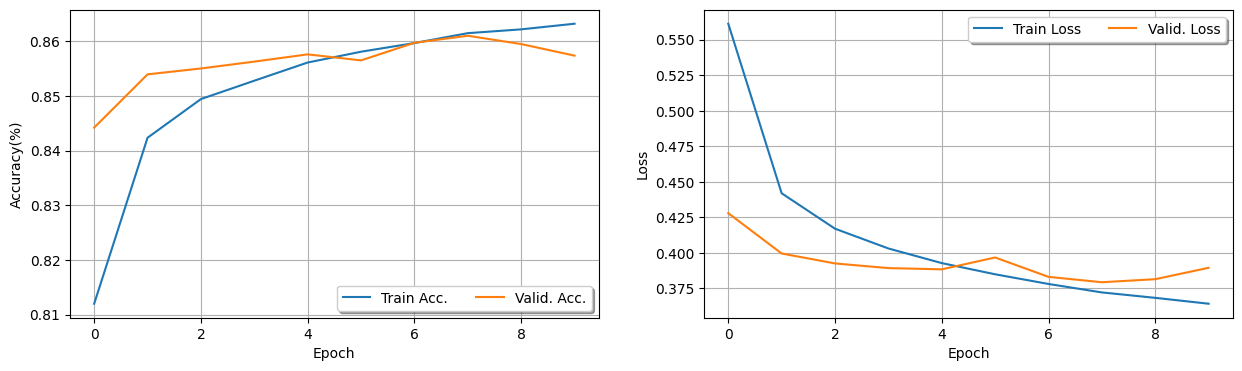

In [24]:
# Valeurs importantes lors de l'apprentissage du modèle
model_train_acc = model_cnn1_history.history['accuracy']
model_valid_acc = model_cnn1_history.history['val_accuracy']
model_train_loss = model_cnn1_history.history['loss']
model_valid_loss = model_cnn1_history.history['val_loss']

# Graphiques de l'apprentissage
fig,(ax0,ax1) = plt.subplots(1, 2, figsize=(15,4))

# Accuracy graph
ax0.plot(model_train_acc, label="Train Acc.")
ax0.plot(model_valid_acc, label="Valid. Acc.")

ax0.set_xlabel('Epoch')
ax0.set_ylabel('Accuracy(%)')
ax0.legend(loc='lower right', fancybox=True, shadow=True, ncol=4)
ax0.grid()

# Loss graph
ax1.plot(model_train_loss, label="Train Loss")
ax1.plot(model_valid_loss, label="Valid. Loss")

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right', fancybox=True, shadow=True, ncol=4)
ax1.grid()

#### CCN Maison 2

##### Modèle

In [27]:
# Définition du deuxième modèle
model_CNN2 = Sequential()

# Convolution 1
model_CNN2.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(28, 28, 1)))
model_CNN2.add(BatchNormalization())
model_CNN2.add(LeakyReLU(alpha=0.1))
model_CNN2.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN2.add(Dropout(0.2))

# Convolution 2
model_CNN2.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model_CNN2.add(BatchNormalization())
model_CNN2.add(LeakyReLU(alpha=0.1))
model_CNN2.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN2.add(Dropout(0.3))

# Convolution 3
model_CNN2.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model_CNN2.add(BatchNormalization())
model_CNN2.add(LeakyReLU(alpha=0.1))
model_CNN2.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN2.add(Dropout(0.4))

# Dense layers
model_CNN2.add(Flatten())
model_CNN2.add(Dense(256))
model_CNN2.add(LeakyReLU(alpha=0.1))
model_CNN2.add(Dropout(0.5))

model_CNN2.add(Dense(num_classes, activation='softmax'))

# Compilation
model_CNN2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Résumé
model_CNN2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 63)             │        16,191 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,927 (1.54 MB)

 Trainable params: 404,479 (1.54 MB)

 Non-trainable params: 448 (1.75 KB)

In [29]:
# Apprentissage du modèle
model_cnn2_history = model_CNN2.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=10)

Epoch 1/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 242s 26ms/step - accuracy: 0.8115 - loss: 0.5554 - val_accuracy: 0.8494 - val_loss: 0.4099
Epoch 2/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 246s 26ms/step - accuracy: 0.8267 - loss: 0.4996 - val_accuracy: 0.8583 - val_loss: 0.3895
Epoch 3/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 251s 27ms/step - accuracy: 0.8309 - loss: 0.4841 - val_accuracy: 0.8586 - val_loss: 0.3878
Epoch 4/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 248s 26ms/step - accuracy: 0.8358 - loss: 0.4667 - val_accuracy: 0.8616 - val_loss: 0.3755
Epoch 5/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 256s 27ms/step - accuracy: 0.8373 - loss: 0.4613 - val_accuracy: 0.8606 - val_loss: 0.3775
Epoch 6/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 267s 28ms/step - accuracy: 0.8384 - loss: 0.4549 - val_accuracy: 0.8621 - val_loss: 0.3737
Epoch 7/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 274s 29ms/step - accuracy: 0.8419 - loss: 0.4463 - val_accuracy: 0.8638 - val_loss: 0.3674
Epoch 8/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 288s 31ms/step - accuracy: 

##### Tableau d'apprentissage

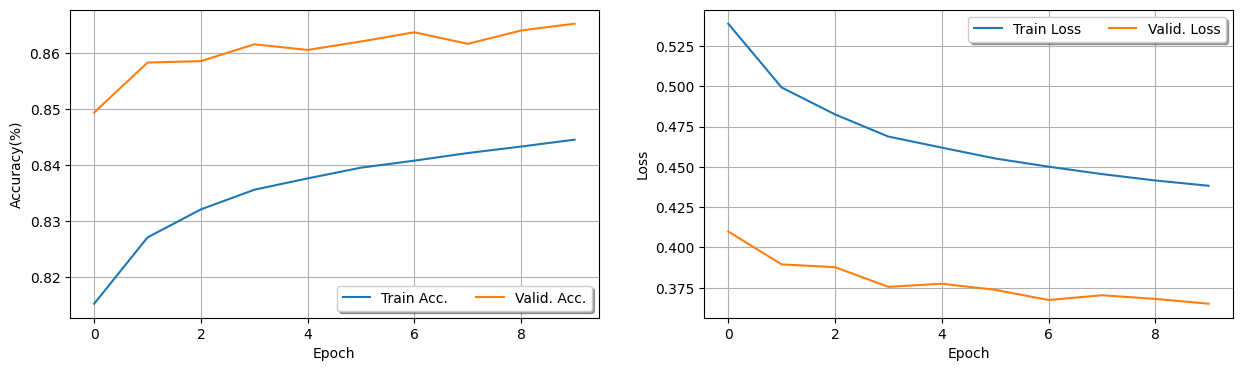

In [30]:
# Valeurs importantes lors de l'apprentissage du modèle
model_train_acc = model_cnn2_history.history['accuracy']
model_valid_acc = model_cnn2_history.history['val_accuracy']
model_train_loss = model_cnn2_history.history['loss']
model_valid_loss = model_cnn2_history.history['val_loss']

# Graphiques de l'apprentissage
fig,(ax0,ax1) = plt.subplots(1, 2, figsize=(15,4))

# Accuracy graph
ax0.plot(model_train_acc, label="Train Acc.")
ax0.plot(model_valid_acc, label="Valid. Acc.")

ax0.set_xlabel('Epoch')
ax0.set_ylabel('Accuracy(%)')
ax0.legend(loc='lower right', fancybox=True, shadow=True, ncol=4)
ax0.grid()

# Loss graph
ax1.plot(model_train_loss, label="Train Loss")
ax1.plot(model_valid_loss, label="Valid. Loss")

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right', fancybox=True, shadow=True, ncol=4)
ax1.grid()

### Option B (Transfert Learning)

#### Transfer Learning 1 (MobileNetV2)

##### Modèle Feature Extraction

In [12]:
# We will use MobileNetV2 as the base model with pre-trained weights
model_TL1_Base = MobileNetV2(weights="imagenet", include_top=False, )  # Adjust input shape

# Freeze the base model so its weights are not updated during training
model_TL1_BASE.trainable = False

model_TL1_FE = models.Sequential([
    # Convert grayscale images (28x28x1) to 3-channel (RGB) images
    layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x)),

    # Use MobileNetV2 as the feature extractor (excluding the top layer)
    base_model,

    # Add global average pooling layer
    layers.GlobalAveragePooling2D(),

    # Add dense layer for classification
    layers.Dense(128, activation='relu'),

    # Add dropout for regularization
    layers.Dropout(0.3),

    # Output layer with 62 classes (for EMNIST Letters)
    layers.Dense(62, activation='softmax')  # 62 classes for letters (A-Z) and digits (0-9)
])

model_CNN1.compile(optimizer=Adam(learning_rate=0.001),
                   loss='categorical_crossentropy',  # Use categorical crossentropy for multi-class classification
                   metrics=['accuracy'])

model_CNN1.fit(model_CNN1, validation_data=test_ds, epochs=10)
print(base_model.summary())


/tmp/ipykernel_7645/3642455015.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False)  # Adjust input shape
2025-06-05 22:31:07.708940: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


NameError: name 'train_ds' is not defined

##### Tableau d'apprentissage (Feature Extraction)

In [ ]:
# TO DO

##### Modèle Fine-tuning

In [25]:
# 1. Unfreeze top layers of the base model
base_model = model_CNN1.layers[0]  # Access MobileNetV2 inside the Sequential
base_model.trainable = True

# 2. Freeze most layers, keep top N trainable
for layer in base_model.layers[:-30]:
    layer.trainable = False

# 3. Recompile with a very low learning rate
from keras.optimizers import Adam
model_TL1_FT.compile(optimizer=Adam(learning_rate=1e-5),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# 4. Continue training
fine_tune_epochs = 3
model_CNN1.fit(train_ds, validation_data=test_ds, epochs=fine_tune_epochs)


Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 209s 653ms/step - accuracy: 0.4825 - loss: 1.8804 - val_accuracy: 0.8160 - val_loss: 0.6565
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 170s 542ms/step - accuracy: 0.7621 - loss: 0.7337 - val_accuracy: 0.8250 - val_loss: 0.6061
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.8169 - loss: 0.5560

2025-05-31 19:22:04.528019: W tensorflow/core/framework/op_kernel.cc:1829] UNKNOWN: KeyError: 0
Traceback (most recent call last):

  File "/home/lizardman/Coding/Projet_Machine_Learning_Air_Drawing/venv312/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/home/lizardman/Coding/Projet_Machine_Learning_Air_Drawing/venv312/lib/python3.12/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/home/lizardman/Coding/Projet_Machine_Learning_Air_Drawing/venv312/lib/python3.12/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 290, in finalize_py_func
    generator_state.iterator_completed(iterator_id)

  File "/home/lizardman/Coding/Projet_Machine_Learning_Air_Drawing/venv312/lib/python3.12/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 872, in iterator_completed
    del 

KeyboardInterrupt: 

##### Tableau d'apprentissage (Fine-tuning)

In [ ]:
# TO DO

#### Transfer Learning 2 (ResNet50V2)

##### Modèle Feature Extraction

In [5]:
# Load EMNIST Letters dataset
def load_emnist_letters(root="./data", train=True):
    return torchvision.datasets.EMNIST(
        root=root,
        split="letters",
        train=train,
        download=False,
        transform=torchvision.transforms.ToTensor()
    )

In [6]:
# Convert EMNIST to numpy arrays
def emnist_to_numpy(dataset, max_samples=None):
    images = []
    labels = []
    for i, (img, label) in enumerate(dataset):
        if max_samples and i >= max_samples:
            break
        img_np = img.numpy().squeeze()
        images.append(img_np)
        labels.append(label - 1)  # EMNIST Letters labels start at 1
    return np.array(images), np.array(labels)

In [ ]:
# Build the transfer learning model
def build_transfer_model():
    base_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model for feature extraction

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [7]:
def build_transfer_model():
    base_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(26, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [8]:
# Batch the data
def create_emnist_tf_dataset(images, labels, batch_size=32, shuffle=True):
    def preprocess(x, y):
        x = tf.stack([x, x, x], axis=-1)
        x = tf.image.resize(x, [224, 224])
        return x, y
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(images))
    ds = ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [9]:
train_dataset = load_emnist_letters(train=True)
test_dataset = load_emnist_letters(train=False)
train_images, train_labels = emnist_to_numpy(train_dataset, max_samples=10000)
test_images, test_labels = emnist_to_numpy(test_dataset, max_samples=2000)
train_ds = create_emnist_tf_dataset(train_images, train_labels)
test_ds = create_emnist_tf_dataset(test_images, test_labels, shuffle=False)

# Train the model
model_CNN1 = build_transfer_model()
history = model_CNN1.fit(train_ds, validation_data=test_ds, epochs=5)

2025-06-02 10:48:09.722188: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 411s 1s/step - accuracy: 0.4048 - loss: 2.0781 - val_accuracy: 0.8180 - val_loss: 0.7326
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 403s 1s/step - accuracy: 0.7332 - loss: 0.8754 - val_accuracy: 0.8605 - val_loss: 0.5165
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 405s 1s/step - accuracy: 0.7973 - loss: 0.6540 - val_accuracy: 0.8565 - val_loss: 0.5230
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 407s 1s/step - accuracy: 0.8299 - loss: 0.5321 - val_accuracy: 0.8395 - val_loss: 0.5296
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 407s 1s/step - accuracy: 0.8486 - loss: 0.4577 - val_accuracy: 0.8510 - val_loss: 0.5006


##### Tableau d'apprentissage (Feature Extraction)

In [10]:
# 1. Unfreeze top layers of the base model
base_model = model_CNN1.layers[0]  # Access MobileNetV2 inside the Sequential
base_model.trainable = True

# 2. Freeze most layers, keep top N trainable
for layer in base_model.layers[:-30]:
    layer.trainable = False

# 3. Recompile with a very low learning rate
from keras.optimizers import Adam
model_CNN1.compile(optimizer=Adam(learning_rate=1e-5),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# 4. Continue training
fine_tune_epochs = 3
model_CNN1.fit(train_ds, validation_data=test_ds, epochs=fine_tune_epochs)

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 562s 2s/step - accuracy: 0.6682 - loss: 1.0963 - val_accuracy: 0.8600 - val_loss: 0.4901
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 559s 2s/step - accuracy: 0.8768 - loss: 0.3808 - val_accuracy: 0.8830 - val_loss: 0.4257
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 563s 2s/step - accuracy: 0.9236 - loss: 0.2375 - val_accuracy: 0.8940 - val_loss: 0.4086


In [ ]:
# 0. Unfreeze top layers of the base model
base_model = model_CNN1.layers[-1]  # Access MobileNetV2 inside the Sequential
base_model.trainable = True

# 1. Freeze most layers, keep top N trainable
for layer in base_model.layers[:-31]:
    layer.trainable = False

# 2. Recompile with a very low learning rate
from keras.optimizers import Adam
model_CNN1.compile(optimizer=Adam(learning_rate=0e-5),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# 3. Continue training
fine_tune_epochs = 2
model_CNN1.fit(train_ds, validation_data=test_ds, epochs=fine_tune_epochs)

##### Modèle Fine-tuning

In [11]:
# 1. Unfreeze top layers of the base model
base_model = model_CNN1.layers[0]  # Access MobileNetV2 inside the Sequential
base_model.trainable = True

# 2. Freeze most layers, keep top N trainable
for layer in base_model.layers[:-30]:
    layer.trainable = False

# 3. Recompile with a very low learning rate
from keras.optimizers import Adam
model_CNN1.compile(optimizer=Adam(learning_rate=1e-5),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# 4. Continue training
fine_tune_epochs = 3
model_CNN1.fit(train_ds, validation_data=test_ds, epochs=fine_tune_epochs)

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 565s 2s/step - accuracy: 0.9495 - loss: 0.1687 - val_accuracy: 0.8910 - val_loss: 0.3999
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 560s 2s/step - accuracy: 0.9684 - loss: 0.1074 - val_accuracy: 0.8975 - val_loss: 0.3987
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 561s 2s/step - accuracy: 0.9779 - loss: 0.0746 - val_accuracy: 0.9095 - val_loss: 0.3679


##### Tableau d'apprentissage (Fine-tuning)

In [ ]:
# TO DO

## Évaluation Comparative et Analyse Critique
---
Explication et résumer des résultat avec les tableaux etc
Meilleur modele dans quel cas et pourquoi (temps, MSE, accuracy, etc)

## Application réel du projet
---

### Vidéo


In [ ]:
# === Fonctions utilitaires ===
def vider_dossier(dossier):
    if os.path.exists(dossier):
        for f in os.listdir(dossier):
            chemin = os.path.join(dossier, f)
            if os.path.isfile(chemin):
                os.remove(chemin)
    else:
        os.makedirs(dossier)

# === 0. Définition des chemins ===
BASE_DIR = os.path.dirname(os.path.abspath(__file__))

print(BASE_DIR)
video_path = os.path.join(BASE_DIR, 'Result/videos/Lettres/I.mp4')
extracted_dir = os.path.join(BASE_DIR, 'images_extraites')
finger_dir = os.path.join(BASE_DIR, 'finger_find')
frame_interval = 2

# === 1. Nettoyage des dossiers ===
vider_dossier(extracted_dir)
vider_dossier(finger_dir)

# === 2. Extraction des frames ===
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print(f"Erreur : impossible d'ouvrir la vidéo '{video_path}'")
    exit()

fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Vidéo chargée : {total_frames} frames à {fps:.2f} fps")

frame_count = 0
saved_count = 0

while True:
    success, frame = cap.read()
    if not success:
        break

    if frame_count % frame_interval == 0:
        filename = os.path.join(extracted_dir, f"frame_{saved_count:04d}.jpg")
        cv2.imwrite(filename, frame)
        saved_count += 1

    frame_count += 1

cap.release()
print(f"{saved_count} images extraites dans le dossier '{extracted_dir}'")

# === 3. Détection du bout de l'index ===
trace_points = []
img_shape = None
detector = HandDetector(staticMode=True, maxHands=1, detectionCon=0.7)

#for filename in os.listdir(extracted_dir):
for filename in sorted(os.listdir(extracted_dir)):
    if not filename.endswith(('.jpg', '.png')):
        continue

    image_path = os.path.join(extracted_dir, filename)
    image = cv2.imread(image_path)
    hands, img = detector.findHands(image)

    if hands:
        hand = hands[0]
        lm_list = hand['lmList']
        if len(lm_list) >= 9:
            x, y = lm_list[8][0], lm_list[8][1]
            trace_points.append((x, y))

    #cv2.imwrite(os.path.join(finger_dir, filename), img)

# === 4. Génération de l'image composite ===
#sample_img = cv2.imread(os.path.join(finger_dir, os.listdir(finger_dir)[0]))
if img_shape is None:
    img_shape = image.shape

height, width, _ = img_shape
result = np.zeros((height, width, 3), dtype=np.uint8)

for i in range(1, len(trace_points)):
    cv2.line(result, trace_points[i - 1], trace_points[i], (0, 0, 255), thickness=6)

# === 5. Rotation de 90° vers la droite ===
rotated = cv2.rotate(result, cv2.ROTATE_90_CLOCKWISE)

# === 6. Effet miroir (symétrie horizontale) ===
mirrored = cv2.flip(rotated, 1)

# === 7. Sauvegarde de l'image finale ===
cv2.imwrite("../image_resultat.png", mirrored)
print("Image finale enregistrée sous 'image_resultat.png' (rotation + effet miroir)")


### Traitements d'image

In [ ]:
def save_step_logs(image, name, output_dir="debug_steps"):
    os.makedirs(output_dir, exist_ok=True)
    if image is None or image.size == 0:
        print(f"[WARNING] Cannot save '{name}': image is empty.")
        return
    cv2.imwrite(os.path.join(output_dir, f"{name}.png"), image)

# Step 1: Extract red from image
def extract_red_mask(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_red1 = np.array([0, 70, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 70, 50])
    upper_red2 = np.array([180, 255, 255])
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    return cv2.bitwise_or(mask1, mask2)

# Step 2: Basic cleaning (open/close)
def clean_mask(mask):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    return cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Step 3: Keep relevant parts
def filter_components(mask, min_area=50):
    labeled = label(mask)
    cleaned = np.zeros_like(mask)
    for region in regionprops(labeled):
        if region.area >= min_area:
            for y, x in region.coords:
                cleaned[y, x] = 255
    return cleaned

# Step 4: Skeletonize
def get_skeleton(mask):
    return (skeletonize(mask > 0) * 255).astype(np.uint8)

# Step 5 : Bold the ligne
def thicken_mask(mask, size=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (size, size))
    return cv2.dilate(mask, kernel, iterations=1)

# Step 6: Resize and center
def center_and_resize(mask, output_size=28, margin=2):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return np.ones((output_size, output_size), dtype=np.uint8) * 255
    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    cropped = mask[y:y+h, x:x+w]
    resized = cv2.resize(cropped, (output_size - 2 * margin, output_size - 2 * margin))
    canvas = np.ones((output_size, output_size), dtype=np.uint8) * 255
    cx = (output_size - resized.shape[1]) // 2
    cy = (output_size - resized.shape[0]) // 2
    canvas[cy:cy + resized.shape[0], cx:cx + resized.shape[1]] = 255 - resized

    return canvas

# Main function
def process_image(path, output_dir="debug_steps"):
    img = cv2.imread(path)
    save_step_logs(img, "00_original", output_dir)

    mask = extract_red_mask(img)
    save_step_logs(mask, "01_red_mask", output_dir)

    cleaned = clean_mask(mask)
    save_step_logs(cleaned, "02_cleaned", output_dir)

    filtered = filter_components(cleaned)
    save_step_logs(filtered, "03_filtered", output_dir)

    skeleton = get_skeleton(filtered)
    save_step_logs(skeleton, "04_skeleton", output_dir)

    thickened = thicken_mask(skeleton, size=50)
    save_step_logs(thickened, "05_thickened", output_dir)

    final = center_and_resize(thickened)
    save_step_logs(final, "06_final", output_dir)

    print("[INFO] Simplified processing complete.")
    cv2.imwrite(os.path.join("../Resultats/Conversion", "result.png"), final)

    return final

# Run on your image
process_image("../image_resultat.png")

### Application du Meilleur Modèle entrainé sur l'image


In [ ]:
# TO DO

## Conclusions et Décisions
---
TO DO